# General SIR ODE model

The general SIR ODE model is a system of three differential equations for the population of size $n$, divided into three subpopulations $S$ (susceptible), $I$ (infectious) and $R$ (removed), parametrised by the following equations:

$$ \frac{dS}{dt} = - \frac{\beta S I}{n} $$

$$ \frac{dI}{dt} = \frac{\beta S I}{n} - \gamma I $$

$$ \frac{dR}{dt} = \gamma I $$

It follows further from the assumption of static demographics that

$$ S + I + R = n $$

and

$$ \frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0 $$

In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    Sdot = - beta * S * I / N 
    Idot = (beta * S * I) / N - gamma * I
    Rdot = gamma * I
    return Sdot, Idot, Rdot

In [3]:
def solve_sir(gamma, R0, N = 1e4, t_days = 90):
    I_0 = 0.001*N
    R_0 = 0.0
    S_0 = N - I_0 - R_0
    beta = R0 * gamma
    t = np.linspace(0, t_days, t_days)
    
    y_0 = S_0, I_0, R_0
    
    res = odeint(sir_model, y_0, t, args=(N, beta, gamma)).T
    return res[0], res[1], res[2], t

In [4]:
def plot_single_sir(S, I, R, t, inverse_gamma, R0):
    fig = plt.figure(facecolor="w")
    ax = fig.add_subplot(111, facecolor="#dddddd", axisbelow=True)
    ax.plot(t, S, "b", alpha=0.5, lw=2, label="Susceptible")
    ax.plot(t, I, "r", alpha=0.5, lw=2, label="Infected")
    ax.plot(t, R, "g", alpha=0.5, lw=2, label="Removed")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Subpopulation size")
    ax.text(0, 7000, "$R_0$: 2.63", fontsize=12)
    ax.text(0, 6000, "$\gamma$: 1/18", fontsize=12)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which="major", c="w", lw=2, ls="-")
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ("top", "right", "bottom", "left"):
        ax.spines[spine].set_visible(False)
    plt.show()

In [20]:
def create_plot_grid(R0_min=1.5, R0_max=6.5, R0_steps=5, inv_gamma_min=8.5-3.9, inv_gamma_max=8.5+3.9, inv_gamma_steps=5, days=90, save=True):
    fig = plt.figure(figsize = (14, 20))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    R0_space = np.linspace(R0_min, R0_max, R0_steps)
    gamma_space = np.linspace(inv_gamma_min, inv_gamma_max, inv_gamma_steps)

    for idxx, valx in enumerate(R0_space):
        for idxy, valy in enumerate(gamma_space):
            R0 = valx
            gamma = 1.0/valy
            S, I, R, t = solve_sir(gamma, R0, t_days=days)
            ax = fig.add_subplot(5, 5, idxx*5 + (idxy+1))
            ax.plot(t, S, "b", alpha=0.5, lw=2, label="Susceptible")
            ax.plot(t, I, "r", alpha=0.5, lw=2, label="Infected")
            ax.plot(t, R, "g", alpha=0.5, lw=2, label="Removed")
            plot_label = "$R_0$: " + str(valx) + ", " + "$\gamma^{-1}$: " + str(valy)
            ax.set_title(plot_label)
            ax.yaxis.set_tick_params(length=0)
            ax.xaxis.set_tick_params(length=0)
            ax.grid(b=True, which="major", c="w", lw=2, ls="-")
            #legend = ax.legend()
            #legend.get_frame().set_alpha(0.5)
            for spine in ("top", "right", "bottom", "left"):
                ax.spines[spine].set_visible(False)
            ax.set_xlabel("Time (days)")
            ax.set_ylabel("Subpopulation size")


    if save:
        plt.savefig("../paper/figures/fig1-odes.pdf")
    
    plt.show()

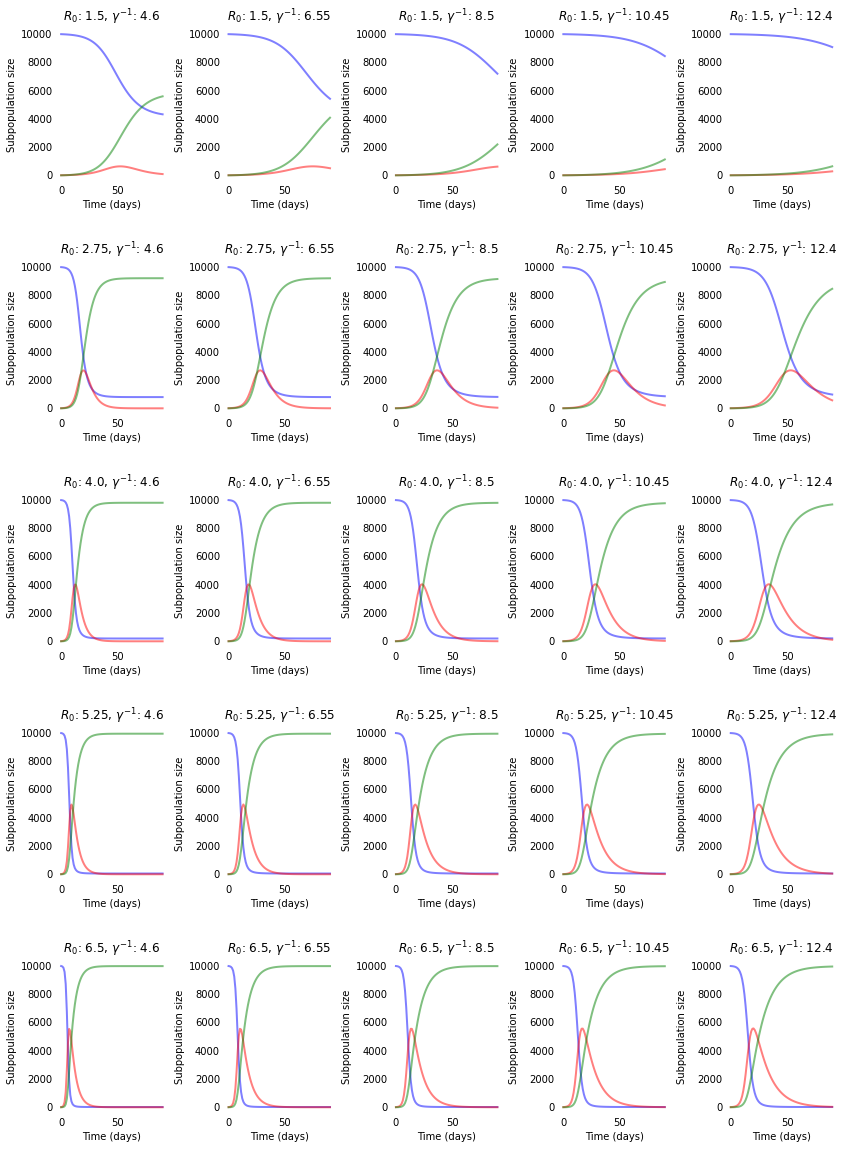

In [21]:
create_plot_grid()

# Strategy diagrams based on social distancing

Let $\bar{\sigma}(P)$ denote the average engagement (in the terms of Reluga (2010), the 'investment') of the population $P$, with $0 \leq \bar{\sigma}(P) \leq 1$, where $1$ stands for a strategy of pure and perfect adherence to social distancing and $0$ stands for no adherence at all. Then, given $R_0$ and $\gamma$, we can conceptualise and calculate outcomes, in dependence on the compliance factor $\delta$ ($\frac{p_d}{n}$, where $p_d$ are those members of $P$ that are engaged in social distancing).

In [7]:
def sir_strategy_model(y, t, N, delta, beta, gamma):
    S, I, R = y
    Sdot = - (1-delta) * beta * S * I / N 
    Idot = (1-delta) * (beta * S * I) / N - gamma * I
    Rdot = gamma * I
    return Sdot, Idot, Rdot

In [8]:
@np.vectorize
def solve_strategy_for_cumulative_infected(delta, R0, days=14, N = 1e4, gamma=1.0/8.5):
    I_0 = 0.001*N
    R_0 = 0.0
    S_0 = N - I_0 - R_0
    beta = R0 * gamma
    t = np.linspace(0, days, days)

    y_0 = S_0, I_0, R_0

    res = odeint(sir_strategy_model, y_0, t, args=(N, delta, beta, gamma)).T
    return max(res[1])

In [9]:
def plot_contours_for_days(sigma_min=0, sigma_max=1, R0_min=1.5, R0_max=6.5, days=[14, 21, 28, 35], save=True):
        
    R0_space = np.linspace(R0_min, R0_max, 100)
    sigma_space = np.linspace(sigma_min, sigma_max, 100)
    
    fig = plt.figure(figsize = (15, 4))
    fig.subplots_adjust(wspace=0.5)
    
    for idx, val in enumerate(days):
        z = solve_strategy_for_cumulative_infected(sigma_space[:, None], R0_space[None, :], val)
        ax = fig.add_subplot(1, len(days), idx + 1)
        contours = ax.contour(R0_space, sigma_space, z, cmap="viridis", levels = [100, 250, 500, 1000, 2000, 3000, 4000, 5000, 6000])
        ax.clabel(contours, inline=True, fontsize = 8, fmt="%1.f")
        ax.set_title(f"{val} days")
        ax.set_xlabel(r"$R_0$")
        ax.set_ylabel(r"$\delta(P)$")
        
    if save:
        plt.savefig("../paper/figures/fig2-strategy_solutions_by_days.pdf")

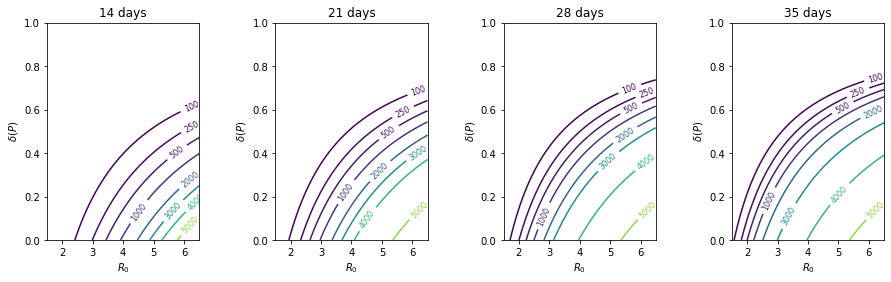

In [10]:
plot_contours_for_days()

# Calculating population dynamics with social distancing

For simplicity's sake, let us assume that social distancing is universal, i.e. those who do engage in social distancing are proportionally equally distributed among the $S$, $I$ and $R$ sub-populations (for COVID-19, due to the relatively low rates of testing, the relatively common clinical characteristics and the relatively frequent asymptomatic cases, this assumption is less illusory than it would be for many other infectious diseases). Then, we can rewrite the SIR equations as

$$ \frac{dS}{dt} = - \frac{\beta S I - \beta \delta S I}{n} $$

$$ \frac{dI}{dt} = \frac{\beta S I - \beta \delta S I}{n} - \gamma I $$

$$ \frac{dR}{dt} = \gamma I $$

which in effect removes a fraction of all susceptibles from liability to infection owing to their social distancing.

In [11]:
def sir_with_distancing(y, t, N, beta, gamma, R0, delta):
    S, I, R = y
    Sdot = - (beta * S * I - beta * delta * S * I) / N 
    Idot = (beta * S * I - beta * delta * S * I) / N - gamma * I
    Rdot = gamma * I
    return Sdot, Idot, Rdot

In [12]:
@np.vectorize
def solve_sir_with_distancing(delta, R0, N = 1e4, gamma=1.0/8.5, days=100):
    I_0 = 0.001*N
    R_0 = 0.0
    S_0 = N - I_0 - R_0
    beta = R0*gamma
    t = np.linspace(0, days, days)
    
    y_0 = S_0, I_0, R_0
    
    res = odeint(sir_with_distancing, y_0, t, args=(N, beta, gamma, R0, delta)).T
    
    return res

In [13]:
def plot_sir_with_distancing(days=100, R0=2.67, save=True):
    fig = plt.figure(figsize = (15, 6))
    fig.subplots_adjust(hspace=0.5, wspace=0.2)

    S, I, R = [], [], []
    
    delta_space = np.linspace(0, 1, 100)
    t_space = np.linspace(0, days, days)
    
    for idx, val in enumerate(delta_space):
        _S, _I, _R = solve_sir_with_distancing(val, R0)
        S.append(_S)
        I.append(_I)
        R.append(_R)

    axS = fig.add_subplot(1, 3, 1)
    contours = axS.contour(t_space, delta_space, S, cmap="viridis")
    axS.clabel(contours, inline=True, fontsize = 8, fmt="%1.f")
    axS.set_title(f"Susceptible")
    axS.set_xlabel(r"days")
    axS.set_ylabel(r"$\delta(P)$")

    axI = fig.add_subplot(1, 3, 2)
    contours = axI.contour(t_space, delta_space, I, cmap="viridis")
    axI.clabel(contours, inline=True, fontsize = 8, fmt="%1.f")
    axI.set_title(f"Infectious")
    axI.set_xlabel(r"days")
    axI.set_ylabel(r"$\delta(P)$")

    axR = fig.add_subplot(1, 3, 3)
    contours = axR.contour(t_space, delta_space, R, cmap="viridis")
    axR.clabel(contours, inline=True, fontsize = 8, fmt="%1.f")
    axR.set_title(f"Removed")
    axR.set_xlabel(r"days")
    axR.set_ylabel(r"$\delta(P)$")

    if save:
        plt.savefig("../paper/figures/fig3-SIR-by-delta.pdf")

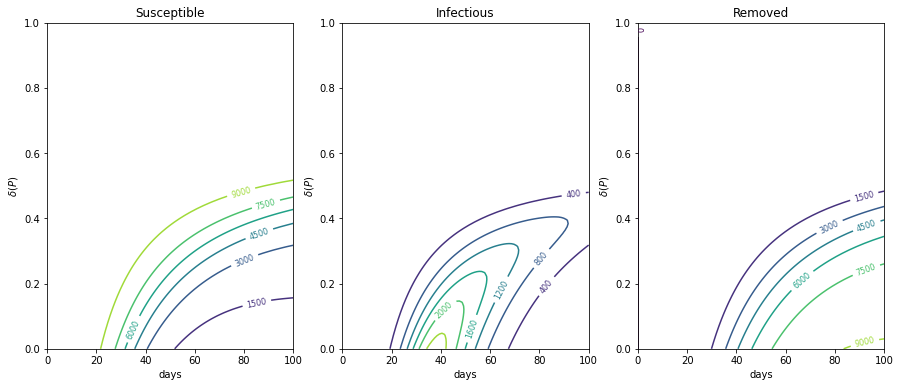

In [14]:
plot_sir_with_distancing()

## Marginal utility of social distancing

The marginal utility of social distancing is the vertical component of the gradient of $I$.

In [15]:
def get_marginal_utility(days=100, R0=2.67, save=True):

    S, I, R = [], [], []
    
    delta_space = np.linspace(0, 1, 100)
    t_space = np.linspace(0, days, days)
    
    for idx, val in enumerate(delta_space):
        _S, _I, _R = solve_sir_with_distancing(val, R0, days=days)
        S.append(_S)
        I.append(_I)
        R.append(_R)

    z = -1 * np.gradient(np.array(S), axis=1)
    fig = plt.figure(figsize = (15, 6))
    contours = plt.contour(t_space, delta_space, z, cmap="viridis", levels=np.linspace(0, 300, 10))
    plt.clabel(contours, inline=True, fontsize = 8, fmt="%1.f")
    plt.xlabel(r"days")
    plt.ylabel(r"$\delta(P)$")

    if save:
        plt.savefig("../paper/figures/marginal_utility.pdf")

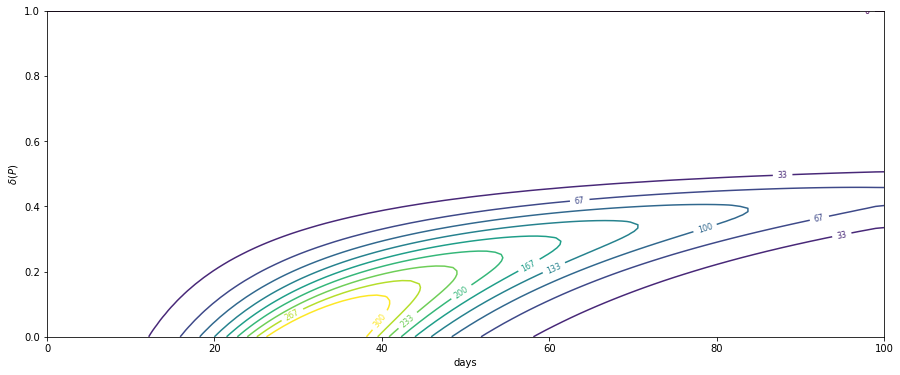

In [16]:
get_marginal_utility()

## Optimum cost fraction

The fraction 

$$ \frac{c_d}{c_i}(P, t) = \frac{(1 - \delta(t)) R_0 \gamma S(t) I(t)}{\delta(t) n^2} $$

for a given value of $\delta(t)$ in a population $n^2$ determines a threshold of optimum strategy.

In [17]:
@np.vectorize
def solve_for_optimum_cost(delta, R0=2.67, N = 1e4, gamma=1.0/8.5, days=100):
    I_0 = 0.001*N
    R_0 = 0.0
    S_0 = N - I_0 - R_0
    beta = R0*gamma
    t = np.linspace(0, days, days)
    
    y_0 = S_0, I_0, R_0
    
    S, I, R = odeint(sir_with_distancing, y_0, t, args=(N, beta, gamma, R0, delta)).T
    
    return ((1 - delta)*R0*gamma*S*I)/(delta * N**2)

In [18]:
def plot_optimum_cost_over_time(days=90, save=True):
    
    delta_space = np.linspace(0, 1, 100)
    t_space = np.linspace(0, days, days)
    
    cost_fraction = []
    
    for idx, val in enumerate(delta_space):
        cost_fraction.append(solve_for_optimum_cost(val, days=days))

    z = np.array(cost_fraction)
    print(z.shape)
    fig = plt.figure(figsize = (15, 6))
    contours = plt.contour(t_space, delta_space, z, cmap="RdGy", levels=[0.0001, 0.00025, 0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 1])
    plt.clabel(contours, inline=True, fontsize = 8, fmt="%1.4f")
    plt.xlabel(r"days")
    plt.ylabel(r"$\delta(P)$")
    
    if save:
        plt.savefig("../paper/figures/cost_fraction.pdf")

/Users/csefalvayk/Developer/social-distancing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/csefalvayk/Developer/social-distancing/venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: divide by zero encountered in ? (vectorized)
  outputs = ufunc(*inputs)


(100, 90)


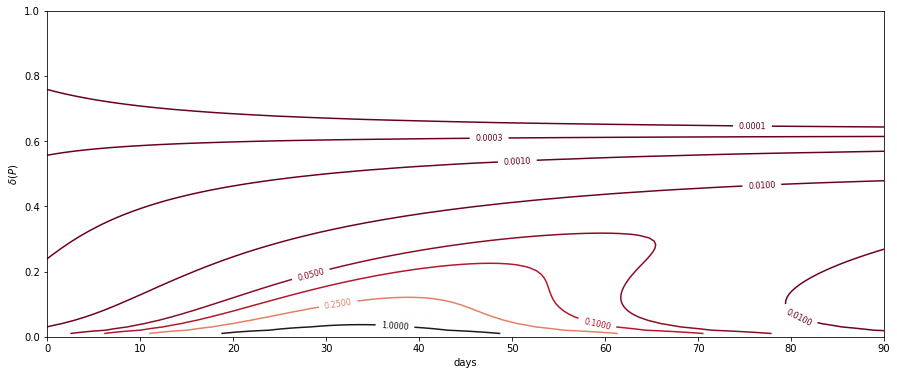

In [19]:
plot_optimum_cost_over_time()